<a href="https://colab.research.google.com/github/carrot1301/Equity-Research-Assistant-Toolkit/blob/main/Equity_Research_Assistant_Toolkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universal Equity Research Notebook
## Vietnam Market (vnstock3) & Global Market (Yahoo Finance)

This notebook simulates the workflow of an Equity Research team:
- Market monitoring
- Risk analysis
- Key indicators for research reports
- Fundamental valuation (DCF)
- Systematic investment conclusion

Data sources:
- Vietnam stocks & VNIndex: vnstock3 (OOP version)
- Global stocks & S&P500: Yahoo Finance

This is an academic project, not an investment recommendation.

## Install required libraries


In [1]:
!pip install -U vnstock yfinance

In [2]:
import os
os.environ["accept_term_and_condition"] = "true"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from vnstock import Vnstock

import warnings
warnings.filterwarnings("ignore")

plt.figure()


📋 Connecting Google Drive account
to save project settings.

Mounted at /content/drive


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## 1. Select Stock

Examples:
- Vietnam stocks: FPT, VNM, HPG, VCB
- Global stocks: AAPL, MSFT, NVDA, TSLA


In [12]:
ticker = input("Enter stock ticker (e.g., FPT, VNM, AAPL, MSFT): ").strip().upper()
is_vietnam = ticker.isalpha() and len(ticker) <= 4

print("Selected stock:", ticker)
print("Market type:", "Vietnam" if is_vietnam else "Global")

Enter stock ticker (e.g., FPT, VNM, AAPL, MSFT): VCB
Selected stock: VCB
Market type: Vietnam


## 2. Download Price Data

- Vietnam stocks: vnstock3
- Global stocks: Yahoo Finance

In [13]:
start_date = "2018-01-01"

if is_vietnam:
    vnstock = Vnstock()

    stock = vnstock.stock(symbol=ticker, source="VCI")

    vnindex = vnstock.stock(symbol="VNINDEX", source="VCI")

    stock_df = stock.quote.history(start=start_date)
    index_df = vnindex.quote.history(start=start_date)

    stock_df = stock_df.rename(columns={"close": "Close"})
    index_df = index_df.rename(columns={"close": "Close"})

    stock_df["Date"] = pd.to_datetime(stock_df["time"])
    index_df["Date"] = pd.to_datetime(index_df["time"])

    stock_df = stock_df.set_index("Date")
    index_df = index_df.set_index("Date")

else:
    stock_df = yf.download(ticker, start=start_date, auto_adjust=True, progress=False)
    index_df = yf.download("^GSPC", start=start_date, auto_adjust=True, progress=False)

if len(stock_df) == 0:
    raise ValueError("Failed to download stock data.")

price = pd.DataFrame({
    "STOCK": stock_df["Close"],
    "MARKET": index_df["Close"]
}).dropna()

print("Data starts from:", price.index.min().date())
print("Data ends at:", price.index.max().date())
print("Total observations:", len(price))

price.tail()

2026-01-12 07:36:58 - vnstock.common.data - INFO - Not a stock. Company and finance data unavailable.
INFO:vnstock.common.data:Not a stock. Company and finance data unavailable.


Data starts from: 2022-01-07
Data ends at: 2026-01-12
Total observations: 1000


,STOCK,MARKET
Date,,
2026-01-06,57.3,1816.27
2026-01-07,59.6,1861.58
2026-01-08,63.7,1855.56
2026-01-09,68.0,1867.90
2026-01-12,72.7,1872.16


## 3. Market Movement Overview


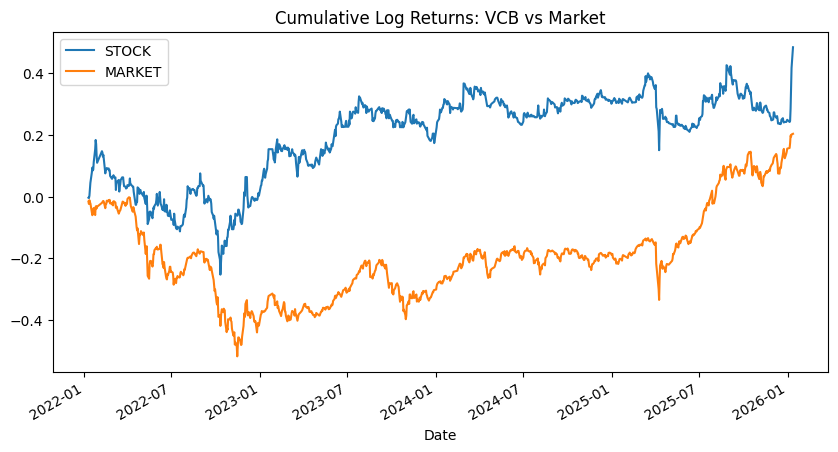

In [14]:
returns = np.log(price / price.shift(1)).dropna()

returns.cumsum().plot(title=f"Cumulative Log Returns: {ticker} vs Market", figsize=(10,5))
plt.show()

## 4. Risk Analysis


In [15]:
vol_stock = returns["STOCK"].std() * np.sqrt(252)
vol_market = returns["MARKET"].std() * np.sqrt(252)

cov = np.cov(returns["STOCK"], returns["MARKET"])
beta = cov[0,1] / cov[1,1]

cum = (1 + returns["STOCK"]).cumprod()
peak = cum.cummax()
drawdown = (cum - peak) / peak
max_dd = drawdown.min()

risk_metrics = pd.Series({
    "Annual Volatility (Stock)": vol_stock,
    "Annual Volatility (Market)": vol_market,
    "Beta": beta,
    "Max Drawdown": max_dd
})

risk_metrics

,0
Annual Volatility (Stock),0.239637
Annual Volatility (Market),0.197382
Beta,0.687048
Max Drawdown,-0.370231


## 5. Key Indicators for Equity Research Report


In [16]:
current_price = price["STOCK"].iloc[-1]

last_252 = price["STOCK"].iloc[-252:] if len(price) >= 252 else price["STOCK"]

high_52w = last_252.max()
low_52w = last_252.min()

avg_daily_return = returns["STOCK"].mean()
total_return = price["STOCK"].iloc[-1] / price["STOCK"].iloc[0] - 1

report_metrics = pd.Series({
    "Current Price": current_price,
    "52W High": high_52w,
    "52W Low": low_52w,
    "Average Daily Return": avg_daily_return,
    "Annual Volatility": vol_stock,
    "Beta": beta,
    "Max Drawdown": max_dd,
    "Total Return (Full Period)": total_return
})

report_metrics

,0
Current Price,72.700000
52W High,72.700000
52W Low,52.120000
Average Daily Return,0.000483
Annual Volatility,0.239637
Beta,0.687048
Max Drawdown,-0.370231
Total Return (Full Period),0.620236


## 6. (Optional) Financial Ratios from vnstock3 (Vietnam only)

In [17]:
if is_vietnam:
    ratios = stock.finance.ratio()
    ratios.head()
else:
    print("Financial statements from vnstock are only available for Vietnam stocks.")

## 7. Financial Inputs for Valuation (Manual Input)


In [18]:
last_fcf = 1000
shares_outstanding = 1000

assumptions = {
    "growth": [0.10, 0.08, 0.07, 0.06, 0.05],
    "wacc": 0.12,
    "terminal_growth": 0.03
}

## 8. DCF Valuation


In [19]:
fcf_forecast = []
current_fcf = last_fcf

for g in assumptions["growth"]:
    current_fcf = current_fcf * (1 + g)
    fcf_forecast.append(current_fcf)

fcf_forecast = np.array(fcf_forecast)

wacc = assumptions["wacc"]
discount_factors = np.array([(1 / (1 + wacc) ** (i+1)) for i in range(len(fcf_forecast))])

pv_fcf = fcf_forecast * discount_factors

terminal_value = fcf_forecast[-1] * (1 + assumptions["terminal_growth"]) / (wacc - assumptions["terminal_growth"])
pv_terminal = terminal_value / ((1 + wacc) ** len(fcf_forecast))

enterprise_value = pv_fcf.sum() + pv_terminal

fair_price = enterprise_value / shares_outstanding

fair_price

np.float64(13.68066345240264)

## 9. Investment Conclusion


In [20]:
upside = (fair_price - current_price) / current_price

def investment_decision(upside, beta, max_dd):
    if upside > 0.25 and beta < 1.2 and max_dd > -0.5:
        return "BUY"
    elif upside > 0.05:
        return "HOLD"
    else:
        return "SELL"

decision = investment_decision(upside, beta, max_dd)

summary = pd.Series({
    "Current Price": current_price,
    "Fair Value (DCF)": fair_price,
    "Upside": upside,
    "Beta": beta,
    "Max Drawdown": max_dd,
    "System Recommendation": decision
})

summary

,0
Current Price,72.7
Fair Value (DCF),13.680663
Upside,-0.81182
Beta,0.687048
Max Drawdown,-0.370231
System Recommendation,SELL


## 10. Final Notes

- Vietnam market data is sourced from vnstock3 (OOP version)
- Global market data is sourced from Yahoo Finance
- Financial statement inputs must be manually verified in real Equity Research work
- This notebook is designed to support research, not replace analyst judgment
